In [1]:
import warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=UserWarning)
warnings.filterwarnings('ignore',category=ImportWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import pandas as pd
import numpy as np
import time

import category_encoders as ce
from scipy.stats import randint
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from BorutaShap import BorutaShap
from xgboost import XGBClassifier

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, RobustScaler # MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.utils.fixes import loguniform
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
import operator


In [2]:
# Train test split parameters
test_holdout_percentage = 0.10

# Leave One Out Encoder Sigma value - 0.04 is the top performing value.
sigma = 0.03                                                        # Tested parameters: 0.04, 0.05, 0.10, 0.30, 0.60

# BorutaShap parameters
xgb_max_depth = 6                                                   # Tested parameters: 6, 8, 10, with optimal time/performance at 8
feature_model_n_trials = 300

# ADASYN sampling multiplier - 2 is the top performing value.
adasyn_class_multiplier = 2                                         # Tested parameters: 1, 2, 3

# Feature scaler
feature_scaler = RobustScaler()                                     # Tested parameters: MinMaxScaler(), StandardScaler(), MaxAbsScaler(), RobustScaler()

# HalvingRandomSearchCV parameters
scoring = 'accuracy'
n_cross_validation = 5

# Specify the HalvingRandomSearchCV parameters
halving_parameter = 2.0
max_resource = 2000
resource_divisor = 2.0
min_resource = int(round((max_resource / resource_divisor), 0))


In [3]:
# Create timer to calculate total workbook time in hours
start_time = time.time()

## IMPORT PROCESSED NFL-DATA-PY CSV FILE
##### https://pypi.org/project/nfl-data-py/

In [4]:
# Import csv file from nfl-data-py
df = pd.read_csv(r'/Users/ttas2/Documents/Python/nfl-machine-learning-models/output_files/nfl_post_processing_run_pass_classification_data.csv')

df.shape

(60331, 160)

In [5]:
# Print columns with missing values
print(df.columns[df.isnull().any()].tolist())

[]


In [6]:
# Convert binary columns to integers
binary_columns = df.columns[df.isin([0,1]).all()].tolist()
df[binary_columns] = df[binary_columns].apply(pd.to_numeric, downcast='integer', errors='coerce', axis=1)

df.sample(2)

,week,posteam,posteam_type,defteam,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,qtr,...,remain_yds_div_def_dl_count,remain_yds_prod_def_dl_count,remain_yds_div_def_db_count,remain_yds_prod_def_db_count,remain_yds_div_score_diff,remain_yds_prod_score_diff,run_ratio_off_priors,run_ratio_def_priors,posteam_season,defteam_season
9071,12,CAR,away,TEN,32.0,539,539,2339,1,2,...,9.0,36.0,3.0,108.0,-2.571429,-126.0,0.111111,0.194444,car_2023,ten_2023
38566,15,MIN,home,IND,53.0,344,344,344,3,5,...,6.0,96.0,4.8,120.0,0.000000,0.0,0.000000,0.750000,min_2022,ind_2022


In [7]:
# Target frequency
target_count = df.play_type.value_counts(normalize=True)

target_count

play_type
pass    0.598382
run     0.401618
Name: proportion, dtype: float64

In [8]:
df['play_type'] = np.where(df['play_type'] == 'pass', 1, 0)


## TRAIN TEST SPLIT
##### https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [9]:
# split data into target and feature datasets
X, y = df.loc[:, df.columns != 'play_type'], df['play_type']

initial_features = X.columns.to_list()

# Create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_holdout_percentage, random_state=67)

print(X_train.shape[1], 'initial features before processing')

159 initial features before processing


In [10]:
# Used to balancing the effect of XGBClassifier weights on imbalanced dataset: scale_pos_weight = total_majority observations / total minority observations
target_count = y_train.value_counts()

scale_pos_weight = round(target_count[1] / target_count[0], 2)
print('XGBClassifier scale_pos_weight:', scale_pos_weight)

XGBClassifier scale_pos_weight: 1.49


## BASELINE MODEL
##### https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

In [11]:
# Create and fit baseline model to compare performance
baseline_model = DummyClassifier(strategy='most_frequent', random_state=67)
baseline_model.fit(X_train, y_train)

# Calculate model accuracy on test data
y_baseline_pred = baseline_model.predict(X_test)

print(f"Baseline accuracy: {round(accuracy_score(y_test,y_baseline_pred)*100, 1)}%")
print(f"Baseline f1 score: {round(f1_score(y_test,y_baseline_pred)*100, 1)}%")


Baseline accuracy: 59.6%
Baseline f1 score: 74.7%


## ENCODE CATEGORICAL FEATURES
##### https://contrib.scikit-learn.org/category_encoders/leaveoneout.html

In [12]:
# Encoded column represents mean response over all rows for this category, providing one-column representation while avoiding direct response leakage

pre_features = X_train.columns.to_list()
categorical_features = list(X_train.select_dtypes(include='object'))

# Sigma adds normal (Gaussian) distribution noise into training data in order to decrease over-fitting (testing data are untouched). Sigma gives the standard deviation (spread or “width”) of the normal distribution. The optimal value is commonly between 0.05 and 0.6. The default is to not add noise, but that leads to significantly suboptimal results.
encoder = ce.LeaveOneOutEncoder(return_df=True, cols=categorical_features, handle_missing='value', handle_unknown='value', sigma=sigma, random_state=67, drop_invariant=False)

X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

post_features = X_train.columns.to_list()

# Compare 2 lists and identify elements in first list not in second list
def diff(list1, list2):
    return list(set(list1) - set(list2))

print('Total observations in training dataset:', len(X_train))
print('Total features before encoding:', len(pre_features))
print(' ')
print('Dropped features due to invariance:', diff(pre_features, post_features))
print(' ')
print('Features after categorical encoding:', len(post_features))
print('Column names:', X_train.columns.to_list())

Total observations in training dataset: 54297
Total features before encoding: 159
 
Dropped features due to invariance: []
 
Features after categorical encoding: 159
Column names: ['week', 'posteam', 'posteam_type', 'defteam', 'yardline_100', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'qtr', 'down', 'goal_to_go', 'ydstogo', 'shotgun', 'no_huddle', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'posteam_score', 'defteam_score', 'score_differential', 'no_score_prob', 'fg_prob', 'safety_prob', 'td_prob', 'ep', 'wp', 'drive_play_count', 'spread_line', 'total_line', 'div_game', 'roof', 'surface', 'offense_formation', 'offense_personnel', 'defenders_in_box', 'defense_personnel', 'n_offense', 'n_defense', 'report_eligible', 'off_rb_count', 'off_te_count', 'off_wr_count', 'off_hb_count', 'off_ol_count', 'def_dl_count', 'def_lb_count', 'def_db_count', 'wr_to_db_ratio', 'hb_to_lb_ratio', 'ol_to_dl_ratio', 'play_sequence_game', 'play

## FEATURE SELECTION
##### https://pypi.org/project/BorutaShap/

In [13]:
feature_model =  XGBClassifier(booster='gbtree',
                              objective='binary:logistic',
                              max_depth=xgb_max_depth,
                              scale_pos_weight=scale_pos_weight,
                              seed=67,
                              )

In [14]:
# no model selected default is Random Forest
Feature_Selector = BorutaShap(importance_measure='shap',
                              classification=True,
                              model=feature_model,
                              )

Feature_Selector.fit(X=X_train,
                    y=y_train,
                    n_trials=feature_model_n_trials,
                    normalize=True,
                    sample=False,
                    random_state=67,
                    )

100%|██████████| 300/300 [1:35:57<00:00, 19.19s/it]

31 attributes confirmed important: ['half_seconds_div_score_diff', 'remain_yds_div_def_box', 'run_ratio_off_priors', 'game_humidity', 'prev1_yards_gained', 'ep_game_sec_ratio', 'remain_yds_div_def_db_count', 'offense_personnel', 'play_type_prev2', 'total_line', 'defteam_season', 'half_seconds_remaining', 'drive_play_count', 'wp', 'game_temp_div_game_humidity', 'posteam', 'game_seconds_remaining', 'remain_yds_div_score_diff', 'defenders_in_box', 'ydstogo', 'defense_personnel', 'play_type_prev3', 'safety_prob', 'offense_formation', 'posteam_season', 'play_type_prev4', 'down', 'td_prob', 'remaining_yards_per_down', 'play_type_prev1', 'yardline_100']
126 attributes confirmed unimportant: ['n_offense', 'prev2_big_play_run', 'prev1_incomplete_pass', 'prev1_no_huddle', 'drive_qb_hit_pcnt', 'posteam_type', 'prev4_yards_gained', 'prev3_yards_gained', 'defteam_timeouts_remaining', 'off_wr_count', 'def_db_count', 'dtg_34to21', 'prev1_negative_pass', 'def_dl_count', 'prev3_incomplete_pass', 'prev1

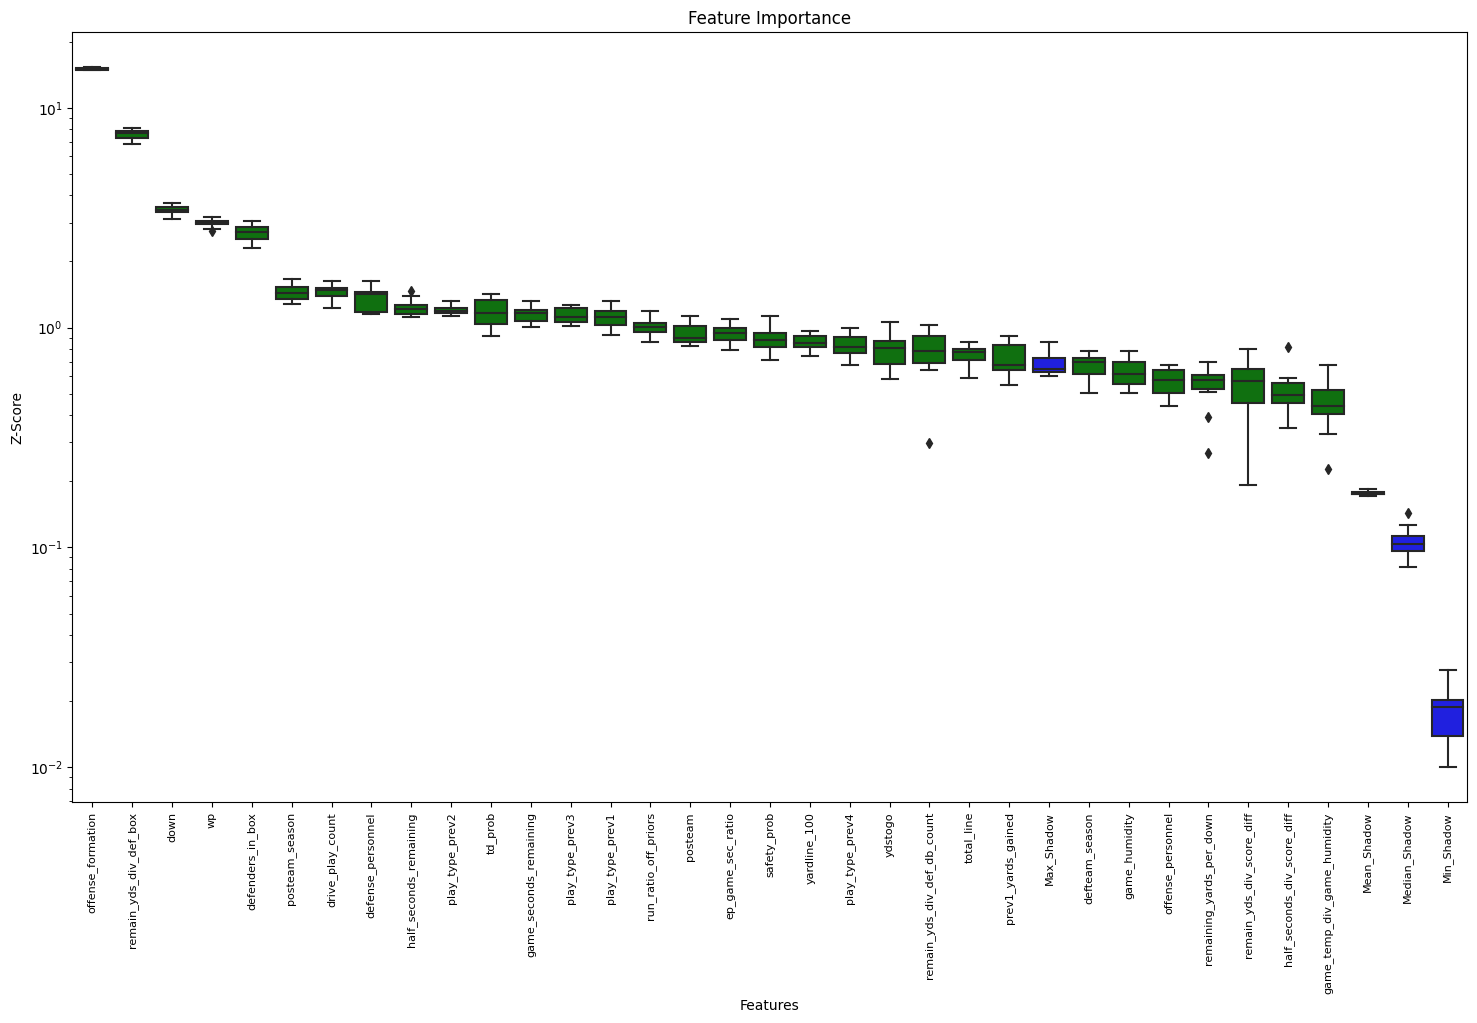

In [15]:
# Plot selected features with shap values on x-axis, angle labeled by shap value, color by feature value
Feature_Selector.plot(which_features='accepted', figsize=(18, 10)) #, y_scale='log')

In [16]:
# Drops features that were identified by BorutaShap as not important
features_to_remove = Feature_Selector.features_to_remove

X_train = X_train.drop(columns=features_to_remove)
X_test = X_test.drop(columns=features_to_remove)

print('Training features:', X_train.shape[1])
print('Testing features:', X_test.shape[1])
print('Most important features:', X_train.columns.to_list())

Training features: 33
Testing features: 33
Most important features: ['posteam', 'yardline_100', 'half_seconds_remaining', 'game_seconds_remaining', 'down', 'ydstogo', 'safety_prob', 'td_prob', 'ep', 'wp', 'drive_play_count', 'total_line', 'offense_formation', 'offense_personnel', 'defenders_in_box', 'defense_personnel', 'game_humidity', 'game_weather', 'play_type_prev1', 'play_type_prev2', 'play_type_prev3', 'play_type_prev4', 'prev1_yards_gained', 'remaining_yards_per_down', 'ep_game_sec_ratio', 'half_seconds_div_score_diff', 'game_temp_div_game_humidity', 'remain_yds_div_def_box', 'remain_yds_div_def_db_count', 'remain_yds_div_score_diff', 'run_ratio_off_priors', 'posteam_season', 'defteam_season']


In [17]:
# Calculate workbook processing time in hours
end_time = time.time()
total_time = end_time - start_time

print('Total time:', round(total_time / 3600, 2), 'hours')

Total time: 1.6 hours


## MODEL PIPELINE
##### https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html
##### https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html
##### https://imbalanced-learn.org/stable/references/over_sampling.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html
##### https://xgboost.readthedocs.io/en/stable/parameter.html

In [18]:
# Create timer to calculate total workbook time in hours
start_time = time.time()

# Create feature type lists for column transform stage of the pipeline
ordinal_features = X_train.columns[X_train.isin([1,2,3,4,5]).all()].tolist()
categorical_features = list(X_train.select_dtypes(include='object'))
boolean_features = X_train.columns[X_train.isin([0, 1]).all()].tolist()

numeric_features = [x for x in X_train.columns if x not in ordinal_features]
numeric_features = [x for x in numeric_features if x not in categorical_features]
numeric_features = [x for x in numeric_features if x not in boolean_features]

#print('categorical features:', len(categorical_features), ':', categorical_features)
print('ordinal features:', len(ordinal_features), ':', ordinal_features)
print('boolean features:', len(boolean_features), ':', boolean_features)
print('numeric features:', len(numeric_features), ':', numeric_features)

ordinal features: 1 : ['down']
boolean features: 0 : []
numeric features: 32 : ['posteam', 'yardline_100', 'half_seconds_remaining', 'game_seconds_remaining', 'ydstogo', 'safety_prob', 'td_prob', 'ep', 'wp', 'drive_play_count', 'total_line', 'offense_formation', 'offense_personnel', 'defenders_in_box', 'defense_personnel', 'game_humidity', 'game_weather', 'play_type_prev1', 'play_type_prev2', 'play_type_prev3', 'play_type_prev4', 'prev1_yards_gained', 'remaining_yards_per_down', 'ep_game_sec_ratio', 'half_seconds_div_score_diff', 'game_temp_div_game_humidity', 'remain_yds_div_def_box', 'remain_yds_div_def_db_count', 'remain_yds_div_score_diff', 'run_ratio_off_priors', 'posteam_season', 'defteam_season']


In [ ]:
# Outlier removal
def iqr_outliers(x, features):

    out_index_list = []
        
    for col in features:
        q1 = np.nanpercentile(x[col], 25.)
        q3 = np.nanpercentile(x[col], 75.)
        
        cut_off = (q3 - q1) * 1.5
        upper, lower = q3 + cut_off, q1 - cut_off
                
        outliers_index = x[col][(x[col] < lower) | (x[col] > upper)].index.tolist()
        out_index_list.extend(outliers_index)
        
    # Remove duplicates
    list(set(out_index_list)).sort()

In [26]:
# Specify the transformations per data type
num_trans = Pipeline(steps=[('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                            ('iqr_outlier', iqr_outliers(X_train, numeric_features)),
                            ('scaler', feature_scaler),
                           ])

cat_trans = Pipeline(steps=[('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                            ('onehot_encoder', OneHotEncoder(sparse=False, handle_unknown='infrequent_if_exist')),
                            ])

ord_trans = Pipeline(steps=[('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                            ('ordinal_encoder', OrdinalEncoder(categories='auto', handle_unknown='error')),
                            ('scaler', feature_scaler),
                           ])
                             
Column_Transform = ColumnTransformer(transformers=[('numeric_transform', num_trans, numeric_features),
                                                   ('categorical_transform', cat_trans, categorical_features),
                                                   ('ordinal_transform', ord_trans, ordinal_features),
                                                   ],
                                     remainder='passthrough',
                                    )

In [27]:
# Specify number of target classes
n_classes = round(y_train.nunique() * adasyn_class_multiplier, 0)

In [28]:
def random_search():
    
    pipeline1 = Pipeline([
    ('col', Column_Transform),
    ('smpl', ADASYN(n_neighbors=n_classes, sampling_strategy='not majority', random_state=67)),
    ('clf', RandomForestClassifier()),
    ])
    
    pipeline2 = Pipeline([
    ('col', Column_Transform),
    ('smpl', ADASYN(n_neighbors=n_classes, sampling_strategy='not majority', random_state=67)),
    ('clf', ExtraTreesClassifier()),
    ])
    
    pipeline3 = Pipeline([
    ('col', Column_Transform),
    ('smpl', ADASYN(n_neighbors=n_classes, sampling_strategy='not majority', random_state=67)),
    ('clf', GradientBoostingClassifier()),
    ])
    
    pipeline4 = Pipeline([
    ('col', Column_Transform),
    ('smpl', ADASYN(n_neighbors=n_classes, sampling_strategy='not majority', random_state=67)),
    ('clf', AdaBoostClassifier()),
    ])

    # RandomForestClassifier
    parameters1 = {
    'clf__bootstrap': [True],
    'clf__ccp_alpha': loguniform(1e-06, 1e-01),               # cost-complexity pruning is an algorithm used to prune a tree to avoid over-fitting
    'clf__criterion': ['gini','entropy'],
    'clf__max_depth': randint(5, 30),
    'clf__max_features': loguniform(0.10, 0.35), 
    'clf__min_impurity_decrease': loguniform(1e-09, 1e-04),
    #'clf__max_samples': loguniform(0.02, 0.49),              # Only for bootstrap=True
    'clf__min_samples_leaf': loguniform(0.005, 0.20),
    'clf__min_samples_split': loguniform(0.005, 0.20),
    'clf__min_weight_fraction_leaf': loguniform(0.005, 0.20),
    'clf__oob_score': [True, False],                                # Only for bootstrap=True
    'clf__warm_start': [True, False],
    'clf__n_jobs': [6],
    'clf__random_state': [67],
    }

    # ExtraTreesClassifier
    parameters2 = {
    'clf__bootstrap': [False],
    'clf__ccp_alpha': loguniform(1e-06, 1e-01),               # cost-complexity pruning is an algorithm used to prune a tree to avoid over-fitting
    'clf__criterion': ['gini','entropy'],
    'clf__max_depth': randint(5, 80),
    'clf__max_features': loguniform(0.50, 0.95),
    'clf__max_leaf_nodes': randint(20, 70),
    #'clf__max_samples': loguniform(0.10, 0.50),               # Only for bootstrap=True
    'clf__min_impurity_decrease': loguniform(1e-05, 1e-01),
    'clf__min_samples_leaf': loguniform(0.05, 0.30),
    'clf__min_samples_split': loguniform(0.005, 0.15),
    'clf__min_weight_fraction_leaf': loguniform(0.05, 0.25),
    'clf__oob_score': [False],                                # Only for bootstrap=True
    'clf__warm_start': [True, False],
    'clf__n_jobs': [6],
    'clf__random_state': [67],
    }
    
    # GradientBoostingClassifier
    parameters3 = {
    'clf__criterion': ['friedman_mse'],
    'clf__ccp_alpha': loguniform(1e-06, 1e-01),                # cost-complexity pruning is an algorithm used to prune a tree to avoid over-fitting
    'clf__learning_rate': loguniform(1e-05, 1e-00),
    'clf__loss': ['log_loss','exponential'],
    'clf__max_depth': randint(25, 60),
    'clf__max_features': loguniform(0.45, 0.85), 
    'clf__max_leaf_nodes': randint(20, 50),
    'clf__min_weight_fraction_leaf': loguniform(0.30, 0.50),   # Must be <= 0.5
    'clf__min_impurity_decrease': loguniform(1e-08, 1e-04),
    'clf__min_samples_leaf': loguniform(0.01, 0.25),
    'clf__min_samples_split': loguniform(0.10, 0.35),
    'clf__n_iter_no_change': [200],
    'clf__tol': loguniform(1e-08, 1e-03),
    'clf__validation_fraction': loguniform(0.05, 0.15),
    'clf__warm_start': [True, False],
    'clf__subsample': loguniform(0.65, 1.00),                  # Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias
    'clf__random_state': [67],
    }

    # AdaBoostClassifier
    parameters4  = {
    'clf__algorithm': ['SAMME','SAMME.R'],
    'clf__learning_rate': loguniform(1e-08, 1e-01),
    'clf__random_state': [67],
    }

    pars = [parameters1, parameters2, parameters3, parameters4]
    pips = [pipeline1, pipeline2, pipeline3, pipeline4]

    result = []
    
    for i in range(len(pars)):
        
        rs = HalvingRandomSearchCV(pips[i],
                                   pars[i],
                                   factor=halving_parameter,
                                   resource='clf__n_estimators',
                                   n_candidates='exhaust',
                                   min_resources=min_resource,
                                   max_resources=max_resource,
                                   scoring=scoring,
                                   aggressive_elimination=False,
                                   return_train_score=True,
                                   refit=True,                   
                                   cv=n_cross_validation,
                                   n_jobs=6,
                                   verbose=1,
                                   random_state=67,
                                   error_score='raise',
                                  )

        # Fit models on training data
        rs = rs.fit(X_train, y_train)
        
        # Apply models to test data to determine model performance
        y_pred = rs.predict(X_test)
        y_pred_prob = rs.predict_proba(X_test)[:, 1]

        print(" ")
        
        # storing model results
        result.append({
        'grid': rs,
        'cv results': rs.cv_results_,
        'train accuracy score': rs.best_score_,
        'best params': rs.best_params_, 
        'best estimator': rs.best_estimator_,
        'feature importance': rs.best_estimator_.named_steps['clf'].feature_importances_,
        'test f1 score': f1_score(y_test, y_pred, average='micro'),
        'test accuracy score': accuracy_score(y_test, y_pred),
        'test balanced accuracy score': balanced_accuracy_score(y_test, y_pred),
        'test roc auc score': roc_auc_score(y_test, y_pred_prob),
        'test classification report': classification_report(y_test, y_pred, target_names=['pass','run'], digits=5),
        'test confusion matrix': confusion_matrix(y_test, y_pred),
        'cv': rs.cv,
        'model #': i + 1
        })

    # sorting results by best test score
    result = sorted(result, key=operator.itemgetter('test f1 score'), reverse=True)
    
    print(' ')
    for element in result:
        if element['model #']==1:
            print('Random Forest classifier: ')
        elif element['model #']==2:
            print('ExtraTrees classifier: ')
        elif element['model #']==3:
            print('GradientBoosting classifier: ')
        elif element['model #']==4:
            print('AdaBoost classifier: ')
        else:
            print('Other: ')  
        
        print('Parameters:  ' + str(element['best params']))
        print(' ')
        print('Train accuracy score:         ' + str(element['train accuracy score']))
        print('Test accuracy score:          ' + str(element['test accuracy score']))
        print('Test balanced accuracy score: ' + str(element['test accuracy score']))
        print('Test f1 score:                ' + str(element['test f1 score']))
        print('Test roc auc score:           ' + str(element['test roc auc score']))
        print(' ')
        print(element['test classification report'])
        print(element['test confusion matrix'])
        print(' ')
        print('-----------------------')
        print(' ')
        
        # Export best model as csv file
        pd.DataFrame(element['cv results']).to_csv(r'/Users/ttas2/Documents/Python/nfl-machine-learning-models/output_files/run_pass_classifier_model.csv')
        pd.DataFrame(element['feature importance'], index=X_train.columns).to_csv(r'/Users/ttas2/Documents/Python/nfl-machine-learning-models/output_files/run_pass_classifier_feature_importance.csv')


In [29]:
%%capture --no-stdout --no-display
random_search()

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1000
max_resources_: 2000
aggressive_elimination: False
factor: 2.0
----------
iter: 0
n_candidates: 2
n_resources: 1000
Fitting 5 folds for each of 2 candidates, totalling 10 fits


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [24]:
# Calculate workbook processing time in hours
end_time = time.time()
total_time = end_time - start_time

print('Total time running pipeline:', round(total_time / 3600, 2), 'hours (not including feature selection time)')

Total time running pipeline: 0.91 hours (not including feature selection time)


## TEST RESULTS FROM SCALING METHODS